# Edward

Main [**link**](http://edwardlib.org/getting-started) to library.

## Installation

### First attempt

My setup: mac 10.12.1.

```bash
python -V
> Python 3.5.2 :: Anaconda 4.2.0 (x86_64)
```

I did not have TensorFlow,

```bash
pip install tensorflow
# (...)
Successfully installed protobuf-3.2.0 tensorflow-0.12.1
```

then

```bash
pip install edward
```

this did not work (it looks like the version of TF was not recent enough). Pip installed version `(0.12.1)`. 

### Latest TF

Heading to https://www.tensorflow.org/versions/r1.0/get_started/os_setup there is a list of systems and steps. For mine (`# Mac OS X, CPU only, Python 3.4 or 3.5:` )

```bash
export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.0.0rc0-py3-none-any.whl
```

followed by

```bash
sudo pip3 install --upgrade $TF_BINARY_URL
# (... takes a while ...)
> Cannot remove entries from nonexistent file (...)/anaconda3/lib/python3.5/site-packages/easy-install.pth
```

great... 

A bit of searching later,

```bash
curl https://bootstrap.pypa.io/ez_setup.py -o - | python
```

Then back to 

```bash
sudo pip3 install --upgrade $TF_BINARY_URL
# (... takes a while ...)
> Successfully installed setuptools-34.1.0 > tensorflow-1.0.0rc0
> (error lines)
```

Nice except that it's followed by a bunch of error lines. There seems to be stuff clashing with Anaconda. Let's try Edward anyway.

```bash
pip install edward
> Successfully built edward
> Installing collected packages: edward
> Successfully installed edward-1.2.1
```

Good! It may have messed up my Anaconda but whatever. (After checking it looks like `numpy`, `pandas` and other essentials still work fine.)


# Playing with Edward

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [29]:
import edward as ed
from edward.models import Normal, Categorical, Bernoulli, Beta
from edward.models import MultivariateNormalFull, Empirical
from edward.models import PointMass

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from keras.layers import Dense
from keras import backend as K

## Bayesian NN

### Generating toy data

Generating data with a cosine dependency $x\rightarrow y$, normal noise.

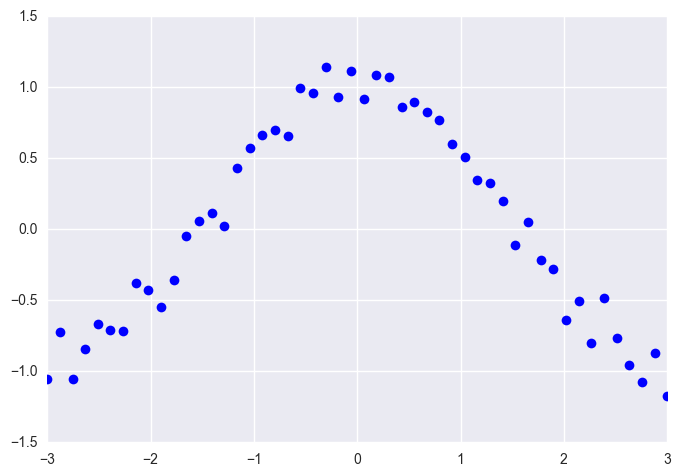

In [3]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

plt.plot(x_train,y_train,ls='none',
    marker='o',color='blue')
plt.savefig("ed1.png")

### Writing the model

Creating a 2-layer BNN

```
    O 
   / \
- O   O -
   \ /
    O
```

First layer consists of two nodes with weights $W_0=(w_{00}, w_{01})$ so after the first layer with tanh nonlinearity we have two vectors:

$ \tanh(xW_0)+b_0 $ of size $n\times 2$

the second layer is made out of a single node with a nonlinearity:

$ (\tanh(x W_0)+b_0) W_1 + b_1$ of size $n\times 1$.


In [5]:
W_0 = Normal(mu = tf.zeros([1, 2]), sigma = tf.ones([1, 2]))
W_1 = Normal(mu = tf.zeros([2, 1]), sigma = tf.ones([2, 1]))
b_0 = Normal(mu = tf.zeros(2),      sigma = tf.ones(2))
b_1 = Normal(mu = tf.zeros(1),      sigma = tf.ones(1))

x = x_train
y = Normal(
        mu    = tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
        sigma = 0.1)

Let's make inferences about the model using **variational inference**. The `tf.Variable` allows the variational factors' parameters to vary (and they are initialised at `0`). Note the `softplus` transformation constraining the standard deviation parameters to be greater than zero. 

$f(x) = \log (1+\exp(x))$

## Determining the variational terms

In [6]:
qW_0 = Normal(mu    = tf.Variable(tf.zeros([1, 2])),
              sigma = tf.nn.softplus(tf.Variable(tf.zeros([1, 2]))))
qW_1 = Normal(mu    = tf.Variable(tf.zeros([2, 1])),
              sigma = tf.nn.softplus(tf.Variable(tf.zeros([2, 1]))))
qb_0 = Normal(mu    = tf.Variable(tf.zeros(2)),
              sigma = tf.nn.softplus(tf.Variable(tf.zeros(2))))
qb_1 = Normal(mu    = tf.Variable(tf.zeros(1)),
              sigma = tf.nn.softplus(tf.Variable(tf.zeros(1))))

## Running the inference

Running VI with the KL divergence and 1000 iterations:

In [7]:
inference = ed.KLqp(
                {W_0: qW_0, b_0: qb_0,
                 W_1: qW_1, b_1: qb_1}, 
                data={y: y_train})
inference.run(n_iter=1000)

Iteration    1 [  0%]: Loss = 4697.446
Iteration  100 [ 10%]: Loss = 1253.839
Iteration  200 [ 20%]: Loss = 198.022
Iteration  300 [ 30%]: Loss = 3.271
Iteration  400 [ 40%]: Loss = 3.217
Iteration  500 [ 50%]: Loss = -8.605
Iteration  600 [ 60%]: Loss = -7.775
Iteration  700 [ 70%]: Loss = 11.145
Iteration  800 [ 80%]: Loss = -7.896
Iteration  900 [ 90%]: Loss = -5.862
Iteration 1000 [100%]: Loss = 14.601


## Visualisation

The **criticism** step

In [8]:
y_post = ed.copy(y, {W_0: qW_0.mean(), b_0: qb_0.mean(), 
                     W_1: qW_1.mean(), b_1: qb_1.mean()})

In [9]:
ed.evaluate('log_likelihood', data={y_post: y_train})

0.70783132

In [10]:
y_meanpost = y_post.mean().eval()
y_sdpost   = y_post.sigma.eval()   

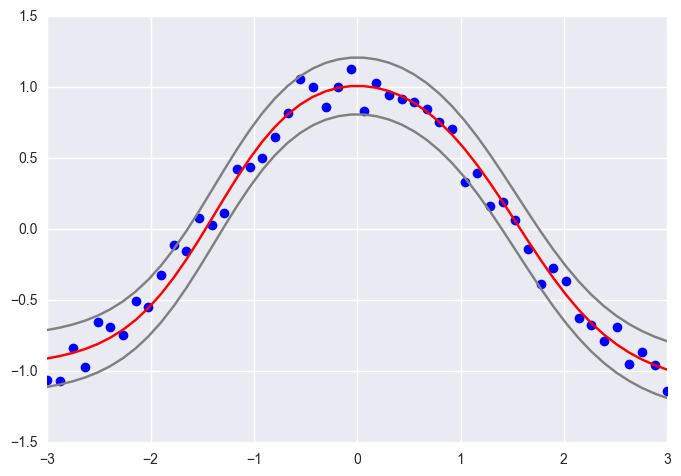

In [11]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

plt.plot(x_train,y_train,ls='none',
    marker='o',color='blue')
plt.plot(x_train,y_meanpost,color='red')
plt.plot(x_train,y_meanpost+2*y_sdpost,color='gray')
plt.plot(x_train,y_meanpost-2*y_sdpost,color='gray')

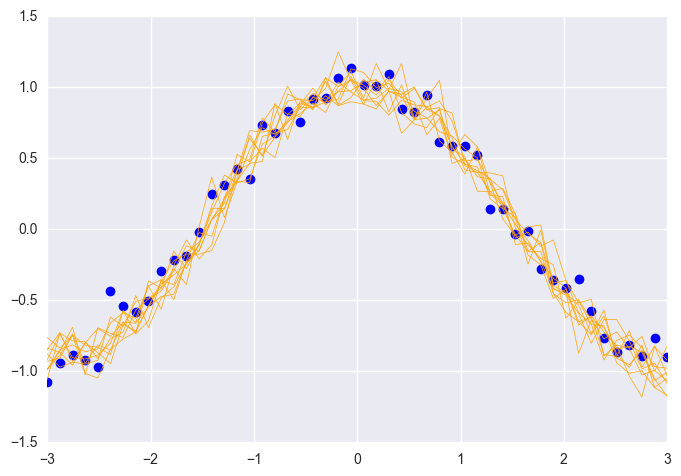

In [12]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

plt.plot(x_train,y_train,ls='none',
    marker='o',color='blue')

for i in range(10):
    ydraw = y_post.sample().eval()
    plt.plot(x_train,ydraw,lw=0.5,color='orange')

# Edward under the hood

## Random variables

### RV: the basics

They are the key *compositional representation*, they are class objects so for example

`Normal <: RandomVariable`

In [14]:
q1 = Normal(mu = 0.0, sigma=1.0)

* Each RV is associated with a tensor $x^\star$ representing a single sample
* This embeds the RV into a computational graph (CG) (nodes=operations on tensors, edges=communication between tensors) $\rightarrow$ allows for composition and parametrisation of RV with complex structures.

Each RV has methods like 

* `log_prob`: $\log p(x|\theta^\star)$
* `mean()`: $\mathbb E_{p(x|\theta^\star)}[x]$
* `sample()`: $x^\star \sim p(x|\theta^\star)$

In [15]:
print(q1.sample().eval())
print(q1.log_pdf(0.0).eval())

0.341688
-0.918939


Note the `eval` since everything is done in TF objects that have to be exposed. This can also be done via the session and TF:

In [16]:
sess = ed.get_session()

In [17]:
sample, mean = sess.run([q1.sample(), q1.mean()])
print(sample)
print(mean)

-0.181091
0.0


### RV: combination (Beta Binomial example)

![](https://i.imgur.com/6tPnaRK.png)

In [19]:
theta = Beta(a=1.0, b=1.0)
x = Bernoulli(p = tf.ones(50) * theta)

x.sample().eval()

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1], dtype=int32)

## Variables

They are objects which are bound to be "deterministic" (i.e. not uncertain) - pointwise evaluation only (e.g. parameters of variational approximations)

In [20]:
theta = tf.Variable(0.)
x = Bernoulli(p=tf.ones(50) * tf.sigmoid(theta))

## Data

Data can either be **preloaded** in a Numpy array or TF constant:

In [21]:
x_data = tf.constant([0, 1, 1, 0, 0])

Or it can be **fed** at run-time in which case it can be declared via a `placeholder` (good for large data)

In [22]:
x_data = tf.placeholder(tf.float32, [100,25])

## Defining a Neural Net (with Keras)


In [27]:
M = 100  # batch size during training
d = 2  # latent dimension

# Probability model (subgraph)
z = Normal(mu = tf.zeros([M, d]), sigma = tf.ones([M, d]))
h = Dense(256, activation='relu')(z.value())
x = Bernoulli(logits=Dense(28 * 28)(h))

In [ ]:
# mnist = input_data.read_data_sets("data/mnist",one_hot=True)

# sess = ed.get_session()
# K.se_session(sess)

# # Bind p(x, z) and q(z|x) to the same TF placeholder for x
# data = {x: x_ph}

# inference = ed.KLqp({z: qz}, data)
# optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
# inference.initialize(optimizer=optimizer)

# init = tf.global_variables_initializer()
# init.run()

# Inference in Edward

In Edward, the standard way of writing things is:

```python
ed.Inference({z: qz}, {x: x_train|})
```

where instead of `Inference` you put one of the implementation such as `MAP`, `KLqp`, `SGHMC`, ... `z` describes a latent variable in the model described and `qz` is the random variables defined to approximate the posterior which are subtypes of `RandomVariable`

* `Empirical`: train of delta for MC-like inference
* `Distribution`: for Variational Inference
* `PointMass`: single value

Combinations can be done easily: e.g. EM:

```python
qbeta = PointMass(params=tf.Variable(tf.zeros([K,D])))
qz    = Categorical(logits=tf.Variable(tf.zeros([N,K])

inference_e = ed.Klqp({z:qz},data={x:x_data,beta:qbeta})
inference_m = ed.MAP({beta:qbeta},data={x:x_data,z:qz})
```

and alternate between the two (unwrap `run`):

```python
for _ in range(10000):
    inference_e.update()
    inference_m.update()
```

Even Message Passing algorithms can be done, EP below.

```python
N1 = 1000
N2 = 2000
D  = 2
K  = 5

beta = Normal(mu=tf.zeros([K,D]),sigma=tf.ones([K,D]))
z1   = Categorical(logits=tf.zeros([N1,K]))
z2   = Categorical(logits=tf.zeros([N2,K]))
x1   = Normal(mu=tf.gather(beta,z1),sigma=tf.ones([N1,D]))
x2   = Normal(mu=tf.gather(beta,z2),sigma=tf.ones([N2,D]))

qbeta = Normal(mu=tf.Variable(tf.zeros([K,D])),
               sigma=tf.nn.softplus(tf.Variable(tf.zeros([K,D]))))
qz1 = Categorical(logits=tf.Variable(tf.zeros([N1,K])))
qz2 = Categorical(logits=tf.Variable(tf.zeros([N2,K])))

inference_z1 = ed.KLpq({beta:qbeta, z1:qz1},{x1:x1_train})
inference_z2 = ed.KLpq({beta:qbeta, z2:qz2},{x2:x2_train})

for _ in range(10000):
    inference_z1.update()
    inference_z2.update()
```

So the local updates are alternated while the global posterior factor $q(\beta)$ is shared across both inferences. 


## Inference algorithms

![alt text](./ed2.png)


Some of those schemes support data subsampling: `MAP`, `KLqp`, `SGLD`.

## Example: VI on Mixture of Gaussians with K means

Mixture of gaussians with $K$ latent cluster means

In [27]:
N = 10000 # number of data points
D = 2     # dimensions
K = 2     # number of clusters

beta = Normal(mu=tf.zeros([K,D]), sigma=tf.ones([K,D]))
z    = Categorical(logits=tf.zeros([N,K]))
x    = Normal(mu=tf.gather(beta, z), sigma=tf.ones([N,D]))

In [28]:
def build_toy_dataset(N):
    pi  = np.array([0.4, 0.6]) # proportions in each cluster 
    mus = [[1, 1], [-1, -1]]   # means of clusters
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
    return x

In [29]:
x_train = build_toy_dataset(N)

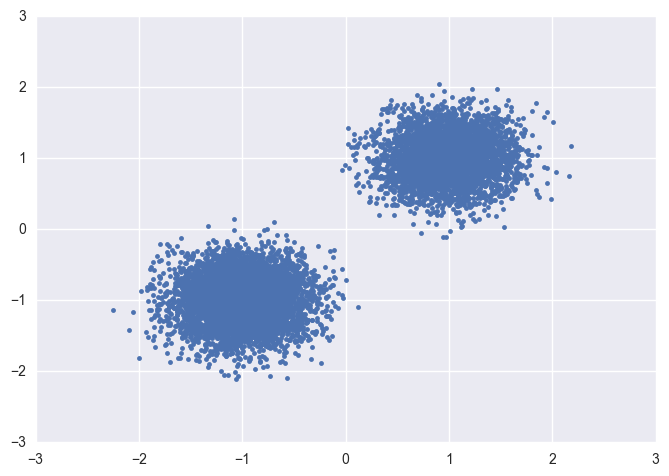

In [30]:
plt.plot(x_train[:,0], x_train[:,1], ls='none', marker='.')

### Let's try VI

In [31]:
# exp here for positivity (see also softplus)
qbeta = Normal(mu    = tf.Variable(tf.zeros([K,D])),
              sigma  = tf.exp(tf.Variable(tf.zeros([K,D])))) 
qz    = Categorical(
              logits = tf.Variable(tf.zeros([N,K])))

inference = ed.KLqp(
                {beta: qbeta, z: qz}, 
                data={x: x_train})

In [32]:
inference.run(n_iter = 5000)

Iteration    1 [  0%]: Loss = 29961.311
Iteration  500 [ 10%]: Loss = 46175.168
Iteration 1000 [ 20%]: Loss = 51927.438
Iteration 1500 [ 30%]: Loss = 43817.160
Iteration 2000 [ 40%]: Loss = 40019.383
Iteration 2500 [ 50%]: Loss = 36567.324
Iteration 3000 [ 60%]: Loss = 35197.863
Iteration 3500 [ 70%]: Loss = 35107.703
Iteration 4000 [ 80%]: Loss = 35597.676
Iteration 4500 [ 90%]: Loss = 36653.379
Iteration 5000 [100%]: Loss = 35774.305


In [33]:
qbeta.mean().eval()

array([[-0.37872237, -0.97730023],
       [ 0.08751977, -0.14160636]], dtype=float32)

## Example: SGHMC

In [38]:
z  = MultivariateNormalFull( 
            mu    = tf.ones(2),
            sigma = tf.constant([[1.0,0.8], [0.8,1.0]]))
qz = Empirical(
            params = tf.Variable(tf.random_normal([5000, 2])))

inference = ed.SGHMC({z:qz})
inference.run(step_size=0.02)

Iteration    1 [  0%]: Acceptance Rate = nan
Iteration  500 [ 10%]: Acceptance Rate = 1.00
Iteration 1000 [ 20%]: Acceptance Rate = 1.00
Iteration 1500 [ 30%]: Acceptance Rate = 1.00
Iteration 2000 [ 40%]: Acceptance Rate = 1.00
Iteration 2500 [ 50%]: Acceptance Rate = 1.00
Iteration 3000 [ 60%]: Acceptance Rate = 1.00
Iteration 3500 [ 70%]: Acceptance Rate = 1.00
Iteration 4000 [ 80%]: Acceptance Rate = 1.00
Iteration 4500 [ 90%]: Acceptance Rate = 1.00
Iteration 5000 [100%]: Acceptance Rate = 1.00


In [39]:
sess = ed.get_session()

In [40]:
mean, std = sess.run([qz.mean(), qz.std()])

In [41]:
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior std:")
print(std)

Inferred posterior mean:
[ 0.94942009  0.92577273]
Inferred posterior std:
[ 0.64785349  0.69260383]


In [42]:
trace = sess.run(qz.params)

In [43]:
# Prepare to plot contours

mu_x, mu_y = sess.run(z.mu)
Sigma = sess.run(z.sigma)
sigma_x, sigma_y = np.sqrt(Sigma[0,0]), np.sqrt(Sigma[1,1])
xmin, xmax = mu_x - 3*sigma_x, mu_x + 3*sigma_x
ymin, ymax = mu_y - 3*sigma_y, mu_y + 3*sigma_y
xs = np.linspace(xmin, xmax, num=250)
ys = np.linspace(ymin, ymax, num=250)
X, Y = np.meshgrid(xs, ys)
T = tf.convert_to_tensor(np.c_[X.flatten(), Y.flatten()], dtype=tf.float32)
Z = sess.run(tf.exp(z.log_prob(T))).reshape((len(xs), len(ys)))

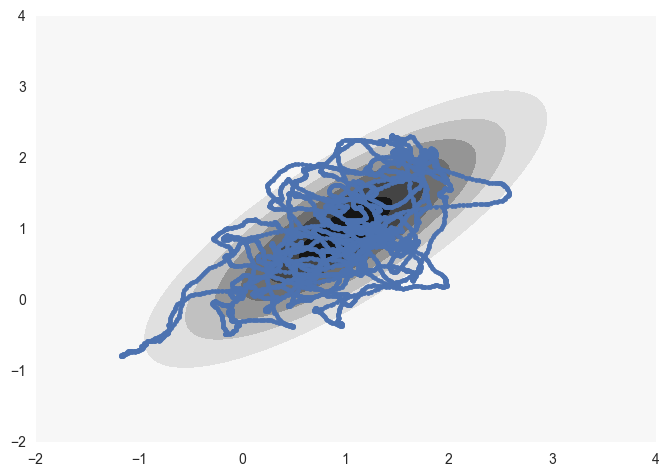

In [44]:
plt.plot(trace[:,0],trace[:,1],marker=".")
plt.contourf(X,Y,Z)

## Example: Bayesian Lin Reg

In [35]:
def build_toy_dataset(N, noise_std=0.5):
    X = np.concatenate([np.linspace(0, 2, num= int(N / 2)),
                      np.linspace(6, 8, num=int(N / 2))])
    y = 2.0 * X + 10 * np.random.normal(0, noise_std, size=N)
    X = X.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return X, y

N = 40  # number of data points
D = 1  # number of features

# DATA
X_train, y_train = build_toy_dataset(N)
X_test, y_test = build_toy_dataset(N)

In [36]:
# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
y = Normal(mu=ed.dot(X, w) + b, sigma=tf.ones(N))

# INFERENCE
T = 5000     # Number of samples.
nburn = 100  # Number of burn-in samples.
stride = 10  # Frequency with which to plot samples.
qw = Empirical(params=tf.Variable(tf.random_normal([T, D])))
qb = Empirical(params=tf.Variable(tf.random_normal([T, 1])))

inference = ed.SGHMC({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(step_size=1e-3)

Iteration    1 [  0%]: Acceptance Rate = nan
Iteration  500 [ 10%]: Acceptance Rate = 1.00
Iteration 1000 [ 20%]: Acceptance Rate = 1.00
Iteration 1500 [ 30%]: Acceptance Rate = 1.00
Iteration 2000 [ 40%]: Acceptance Rate = 1.00
Iteration 2500 [ 50%]: Acceptance Rate = 1.00
Iteration 3000 [ 60%]: Acceptance Rate = 1.00
Iteration 3500 [ 70%]: Acceptance Rate = 1.00
Iteration 4000 [ 80%]: Acceptance Rate = 1.00
Iteration 4500 [ 90%]: Acceptance Rate = 1.00
Iteration 5000 [100%]: Acceptance Rate = 1.00


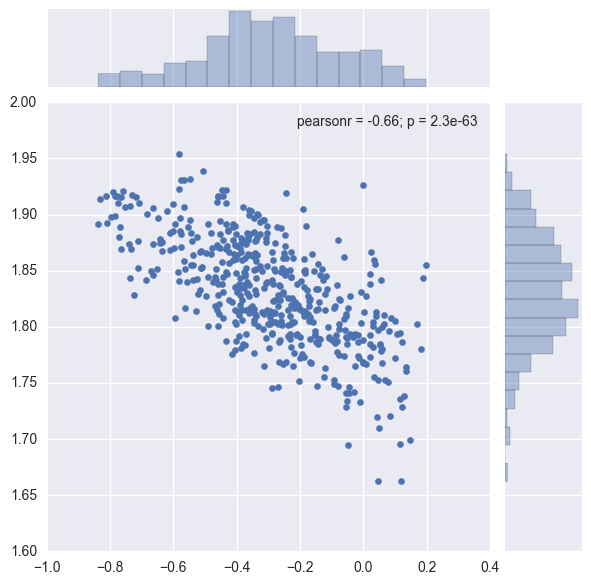

In [37]:
# CRITICISM
# Plot posterior samples.
seaborn.jointplot(qb.params.eval()[nburn:T:stride],
              qw.params.eval()[nburn:T:stride])
plt.show()


In [39]:
# Posterior predictive checks.
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
20.2191


Displaying prior predictive samples.


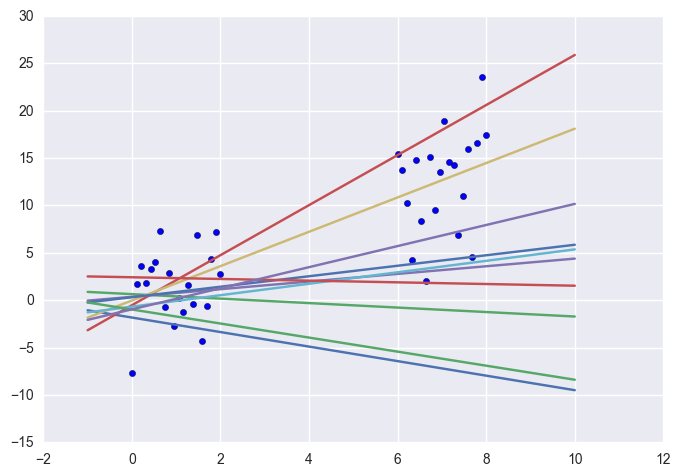

In [40]:
print("Displaying prior predictive samples.")
n_prior_samples = 10

w_prior = w.sample(n_prior_samples).eval()
b_prior = b.sample(n_prior_samples).eval()

plt.scatter(X_train, y_train)
inputs = np.linspace(-1, 10, num=400, dtype=np.float32)
for ns in range(n_prior_samples):
    output = inputs * w_prior[ns] + b_prior[ns]
    plt.plot(inputs, output)


Displaying posterior predictive samples.


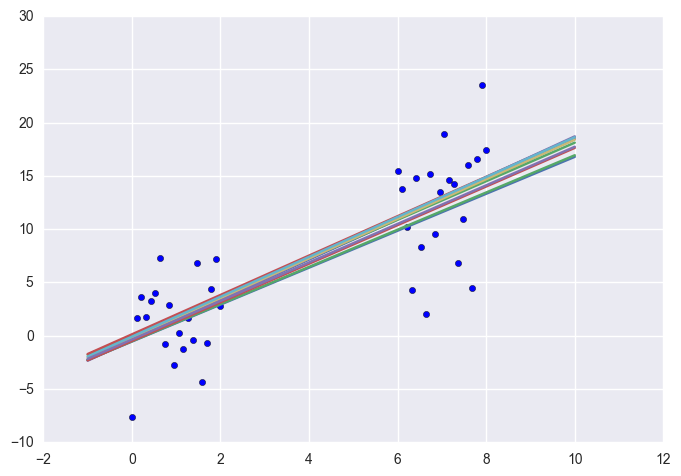

In [41]:
print("Displaying posterior predictive samples.")
n_posterior_samples = 10

w_post = qw.sample(n_posterior_samples).eval()
b_post = qb.sample(n_posterior_samples).eval()

plt.scatter(X_train, y_train)

inputs = np.linspace(-1, 10, num=400, dtype=np.float32)
for ns in range(n_posterior_samples):
    output = inputs * w_post[ns] + b_post[ns]
    plt.plot(inputs, output)

plt.show()